In [1]:
%cd ..
# to be in music-parameters-estimation 

/home/pcallens/music-parameters-estimation


In [2]:
# Load various imports 
import pandas as pd
import os
import librosa
import glob
import numpy as np
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

import pickle

from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from keras.models import load_model
from sklearn import metrics 
from sklearn.model_selection import train_test_split 
import datetime

from tensorflow.keras.callbacks import TensorBoard
#from tensorflow.keras.layers import *
#from tensorflow.keras.models import Sequential
from datetime import datetime

from scipy import stats, signal
import acoustics
from acoustics.signal import bandpass
from acoustics.bands import (_check_band_type, octave_low, octave_high, third_low, third_high)

#from keras.callbacks import TensorBoard
from time import time
from argparse import ArgumentParser

# Custom imports
from utils.models import *

import pandas as pd
from progressbar import progressbar

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='librosa')

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"


Using TensorFlow backend.


In [3]:
from subprocess import call

## 1/ Test with convolved dataset

In [4]:
work_dir = 'datasets/final_ds/'

rir_test_dir = 'datasets/ACE_adapted/RIR_trim/'
audio_test_dir = 'datasets/final_ds/Test/music/'
true_acoustic_values_dir = 'datasets/ACE_adapted/acoustic_values/' #+ os.path.split(os.path.dirname(rir_test_dir))[1] + '/'
mfcc_dir = 'datasets/ACE_adapted/mfcc_music/' 


In [5]:
rir_normed_dir = rir_test_dir.strip('/') + '_sr16000_c_1/'


### Compute true values

### Run convolutions and compute mfcc

In [5]:
audio_duration = 15

call('python convolute.py -audioDir ' + audio_test_dir + 
     ' -rirDir ' + rir_test_dir + 
     ' -outDir ' + mfcc_dir + 
     ' -trim ' + str(audio_duration) +
     ' -outFormat mfcc', shell=True)

0

In [6]:

call('python acoustic_param_ds_maker.py -rirDir ' + rir_normed_dir + 
     ' -outDir ' + true_acoustic_values_dir + 
     ' -params all', shell=True)

0

In [8]:
#replace t60 with the old one with 12 outputs
call('python acoustic_param_ds_maker.py -rirDir ' + rir_normed_dir + 
     ' -outDir ' + 'datasets/final_ds/Test/acoustic_values_final/' + 
     ' -params c50 -bands 500 630 800 1000 1250 1600 2000 2500 3150 4000 5000 6300', shell=True)

0

### Visualize mfcc inputs

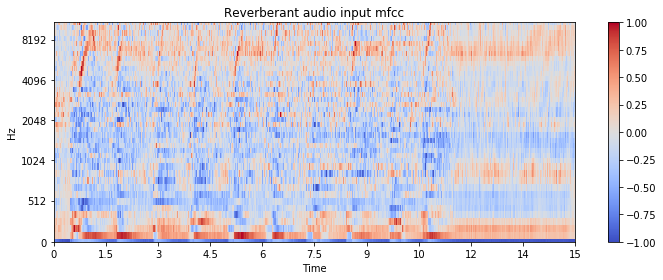

In [96]:
import matplotlib.pyplot as plt
from librosa import display 

with open('datasets/ACE_adapted/mfcc/Building_Lobby_1/F1s5.pkl','rb') as f:
    mfcc = pickle.load(f)
f.close()

sr = 16000
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc[:,:], sr=sr, hop_length= int(0.01*sr), 
                         x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Reverberant audio input mfcc')
plt.tight_layout()
plt.show()


In [11]:
mfcc.shape

(40, 1500)

### Visualize target output

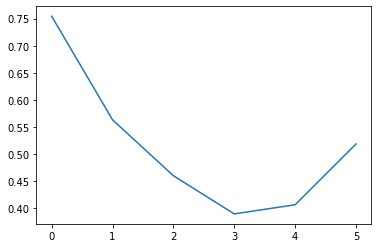

In [63]:
with open('datasets/ACE_adapted/acoustic_values/t60/Meeting_Room_2_1.pkl','rb') as f:
    t60 = pickle.load(f)
f.close()
plt.plot(t60)

# Load model, predict and evaluate

#### 1. Define model

In [9]:
params = {'window_size': 1500,
              'mfcc_bands': 40,
              'n_channels': 1,
              'output_size': 6}

model  = CRNN2D((None,params['mfcc_bands'], 
                 params['window_size'],
                 params['n_channels']), 
                params['output_size'])

In [10]:
model.load_weights("trainings/weights/weights.best.t60_music_RCNN_final.hdf5")
model.compile(loss='mean_squared_error')

#### 2. Make predictions

In [11]:


def predict(mfcc_dir,true_ac_dir,params):
    df = pd.DataFrame(columns = next(os.walk(mfcc_dir))[1],
                     index=next(os.walk(mfcc_dir + next(os.walk(mfcc_dir))[1][0]))[2])

    for room in progressbar(df.columns):
        for track in df.index:
            with open(os.path.join(mfcc_dir,room,track),'rb') as f:
                X = pickle.load(f)
            f.close()

            df.loc[track,room] = model.predict(X.reshape((1,params['mfcc_bands'], 
                                                          params['window_size'],
                                                          params['n_channels'])))
            
    return df

In [12]:
mfcc_dir

'datasets/ACE_adapted/mfcc_music/'

In [13]:
preds_df = predict(mfcc_dir,true_acoustic_values_dir,params)

100% (14 of 14) |########################| Elapsed Time: 0:00:33 Time:  0:00:33


In [11]:
preds_df.head()

Office_2_2  \
music-fma-0000.pkl      [[2.082375, 2.054974, 2.1331713, 1.9115875, 1....   
music-fma-wa-0057.pkl   [[1.9975907, 1.6034305, 1.4951847, 1.3212246, ...   
music-fma-wa-0010.pkl   [[2.2371378, 2.3673916, 2.3052497, 2.0728226, ...   
music-jamendo-0146.pkl  [[1.8227949, 1.578202, 1.4540789, 1.2804444, 1...   
music-fma-0076.pkl      [[1.2393299, 1.1114827, 0.96849513, 0.8165859,...   

                                                         Meeting_Room_1_1  \
music-fma-0000.pkl      [[0.72114766, 0.7590259, 0.85791814, 0.8181661...   
music-fma-wa-0057.pkl   [[1.6643916, 1.3756196, 1.2476147, 1.1139277, ...   
music-fma-wa-0010.pkl   [[2.8964515, 2.8308785, 2.8111176, 2.6972203, ...   
music-jamendo-0146.pkl  [[1.7140363, 1.6927905, 1.5257466, 1.3159263, ...   
music-fma-0076.pkl      [[1.7578989, 1.7268276, 1.4201823, 1.1424145, ...   

                                                         Lecture_Room_1_2  \
music-fma-0000.pkl      [[0.7807604, 1.3396527, 1.9129927, 1.9620267, ...   
music-fma-wa-0057.pkl   [[1.7550635, 1.443563, 1.2870469, 1.128496, 0....   
music-fma-wa-0010.pkl   [[1.8946042, 1.8249118, 1.8802055, 1.8008906, ...   
music-jamendo-0146.pkl  [[2.1470704, 1.9694989, 1.7209158, 1.5153302, ...   
music-fma-0076.pkl      [[0.95037264, 0.7015934, 0.6238268, 0.55797255...   

                                                         Building_Lobby_1  \
music-fma-0000.pkl      [[0.8735212, 0.55283505, 0.48666644, 0.3616398...   
music-fma-wa-0057.pkl   [[1.7891146, 1.5087793, 1.3722005, 1.2160681, ...   
music-fma-wa-0010.pkl   [[2.041061, 2.1842031, 2.1984034, 2.0545564, 1...   
music-jamendo-0146.pkl  [[1.4348572, 1.3986392, 1.3301426, 1.189612, 1...   
music-fma-0076.pkl      [[2.057585, 1.834835, 1.3694754, 1.0088933, 0....   

                                                         Building_Lobby_2  \
music-fma-0000.pkl      [[0.36230534, 0.20877552, 0.21037424, 0.156050...   
music-fma-wa-0057.pkl   [[1.3255515, 1.1195632, 1.0307866, 0.9384472, ...   
music-fma-wa-0010.pkl   [[1.046085, 1.0544872, 1.0266157, 0.96683097, ...   
music-jamendo-0146.pkl  [[1.1897516, 1.1307664, 1.0205064, 0.9297805, ...   
music-fma-0076.pkl      [[1.5623904, 1.5080053, 1.1695493, 0.90564305,...   

                                                         Meeting_Room_1_2  \
music-fma-0000.pkl      [[1.2971133, 1.0343882, 0.9877347, 0.82164097,...   
music-fma-wa-0057.pkl   [[2.4305377, 2.3887892, 2.4561577, 2.3764453, ...   
music-fma-wa-0010.pkl   [[2.311686, 2.5154757, 2.5996912, 2.454866, 2....   
music-jamendo-0146.pkl  [[1.7591333, 1.6297618, 1.5998684, 1.4059874, ...   
music-fma-0076.pkl      [[1.1516463, 0.8991724, 0.6295219, 0.4306373, ...   

                                                               Office_1_2  \
music-fma-0000.pkl      [[1.2310785, 1.3679699, 1.7617048, 1.7540705, ...   
music-fma-wa-0057.pkl   [[1.831621, 1.4174818, 1.5310845, 1.4525217, 1...   
music-fma-wa-0010.pkl   [[2.235353, 2.2429125, 2.3046315, 2.193009, 1....   
music-jamendo-0146.pkl  [[0.8919127, 0.7393184, 0.7480263, 0.6841581, ...   
music-fma-0076.pkl      [[1.1411458, 0.9627283, 0.75947547, 0.55910325...   

                                                         Meeting_Room_2_2  \
music-fma-0000.pkl      [[0.9365238, 0.83779657, 0.83742785, 0.7374877...   
music-fma-wa-0057.pkl   [[1.4759804, 1.3216546, 1.30046, 1.235507, 1.2...   
music-fma-wa-0010.pkl   [[2.9927814, 2.9439764, 2.974179, 2.8616586, 2...   
music-jamendo-0146.pkl  [[1.6571242, 1.3238479, 1.4051169, 1.3460059, ...   
music-fma-0076.pkl      [[0.60210204, 0.3430828, 0.26821065, 0.2397018...   

                                                         Lecture_Room_2_1  \
music-fma-0000.pkl      [[1.3304423, 1.2991116, 1.4830192, 1.3981408, ...   
music-fma-wa-0057.pkl   [[2.0768027, 1.8206084, 1.9354463, 1.8800659, ...   
music-fma-wa-0010.pkl   [[2.5457573, 2.6546938, 2.7051697, 2.581936, 2...   
music-jamendo-0146.pkl  [[1.7446985, 1.5963022, 1.5

In [12]:
def predict_mean(mfcc_dir,true_ac_dir,params):
    df = pd.DataFrame(columns = next(os.walk(mfcc_dir))[1],
                     index=next(os.walk(mfcc_dir + next(os.walk(mfcc_dir))[1][0]))[2])

    for room in progressbar(df.columns):
        for track in df.index:
            with open(os.path.join(mfcc_dir,room,track),'rb') as f:
                X = pickle.load(f)
            f.close()

            df.loc[track,room] = model.predict(X.reshape((1,params['mfcc_bands'], 
                                                          params['window_size'],
                                                          params['n_channels']))).mean()
            
    return df

In [41]:
preds_df_mean = predict_mean(mfcc_dir,true_acoustic_values_dir,params)

100% (14 of 14) |########################| Elapsed Time: 0:00:32 Time:  0:00:32


#### 3. Make target dataframe

In [15]:
target_df = pd.DataFrame(columns = next(os.walk(mfcc_dir))[1],
                     index=next(os.walk(true_acoustic_values_dir))[1])

target_df_mean = pd.DataFrame(columns = next(os.walk(mfcc_dir))[1],
                     index=next(os.walk(true_acoustic_values_dir))[1])

In [16]:
for param in target_df.index:
    for room in target_df.columns:
        with open(os.path.join(true_acoustic_values_dir,param,room) + '.pkl','rb') as f:
            true_val = pickle.load(f)
            target_df_mean.loc[param,room] = true_val.mean()
            target_df.loc[param,room] = true_val
        f.close()

In [17]:
target_df_mean.head()

Office_2_2 Meeting_Room_1_1 Lecture_Room_1_2 Building_Lobby_1  \
drr   -4.89672         -3.08146         -4.97459        -0.237434   
c80    10.8588          10.2143          9.07725          12.0166   
t60   0.452456         0.486698         0.776971          8.49813   
c50    5.93436           6.0037          5.47284          9.52498   
all    3.08724           3.4058          2.58812          7.45058   

    Building_Lobby_2 Meeting_Room_1_2 Office_1_2 Meeting_Room_2_2  \
drr         -4.89813         -4.84004   -5.11544          0.99044   
c80          9.35003          11.4318    12.4849          16.1285   
t60           5.7711         0.492762    0.41221         0.516534   
c50          6.74947          7.11028    7.19353          11.6511   
all          4.24312           3.5487    3.74379          7.32164   

    Lecture_Room_2_1 Lecture_Room_1_1 Meeting_Room_2_1 Office_1_1 Office_2_1  \
drr         0.375344          2.57111         -1.11539   -2.17034   -2.53526   
c80          7.27001          13.9397          13.5166    14.3384    12.3789   
t60          1.41116          0.75772         0.515312   0.476068   0.463069   
c50          5.58965          11.1931          9.07175    9.31568    8.28347   
all          3.66154          7.11542          5.49707    5.48996    4.64754   

    Lecture_Room_2_2  
drr         -4.53692  
c80          4.50047  
t60          1.39895  
c50          2.20245  
all         0.891236

In [45]:
target_df_ace = pd.read_csv('datasets/ACE_adapted/true_vals.csv',index_col=0)

#### 4. Plot

In [46]:
import matplotlib.pyplot as plt
def plot_room_pred(room_name, preds_df, target_df, bands, param):
    track_names = []
    
    NUM_COLORS = preds_df.shape[0]

    cm = plt.get_cmap('hsv')
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    
    
    plt.suptitle(room_name, fontsize=20)
    plt.xscale('linear')
    
    if param == 't60':
        plt.ylim(bottom=0,top=3)
    if param == 'drr':
        plt.ylim(bottom=-20,top=60)
    for index, track in preds_df.iterrows():
        plt.plot(bands,track[room_name][0])
        track_names.append(index)
        
    plt.plot(bands,target_df.loc[param,room_name], color='red', linewidth = 5)
    #plt.legend((track_names))
    plt.show()

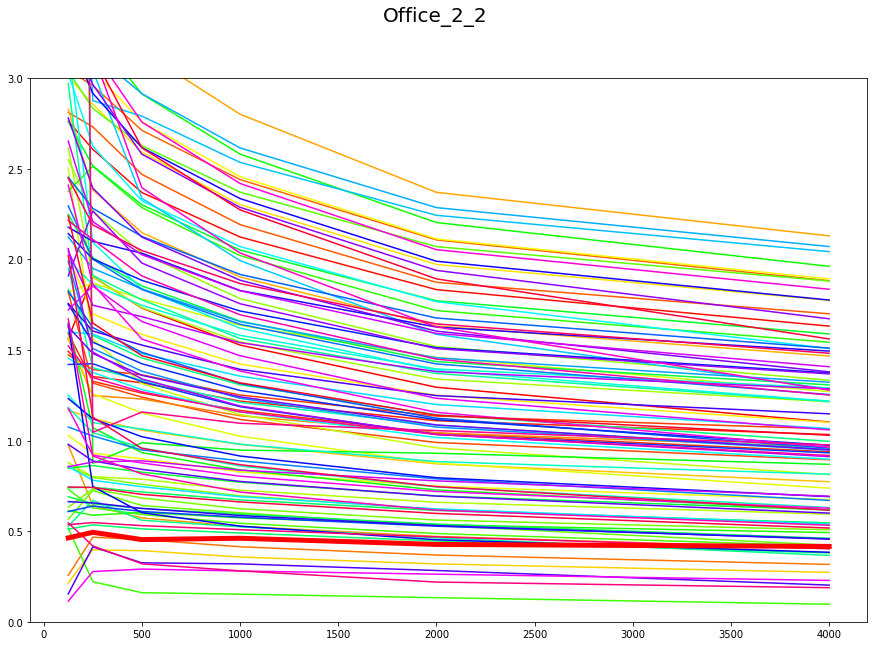

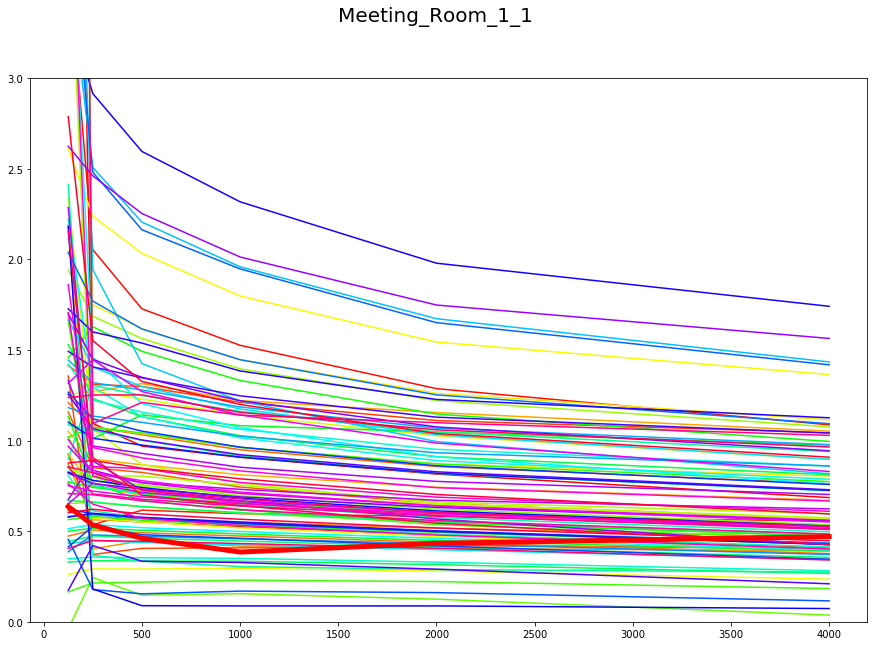

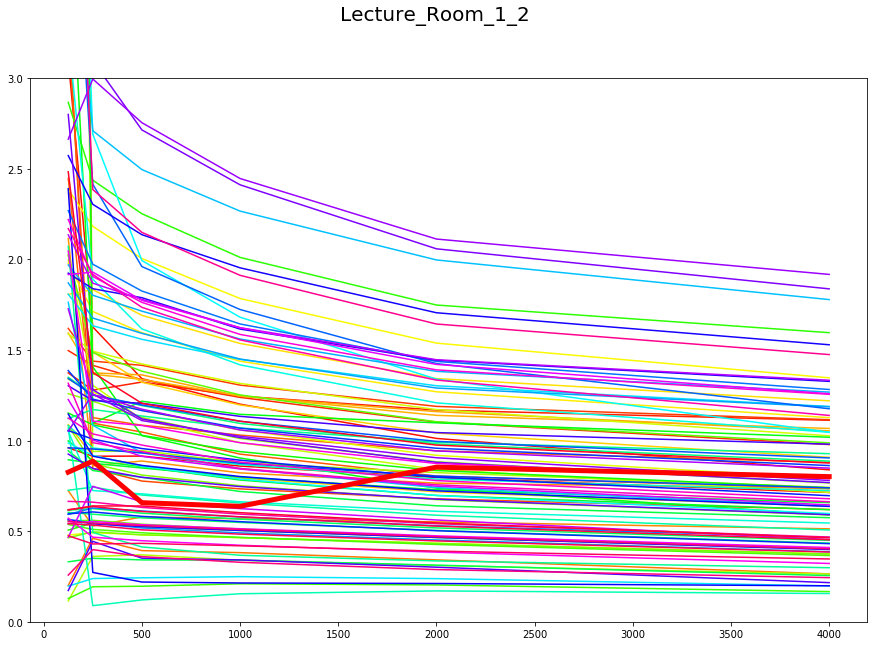

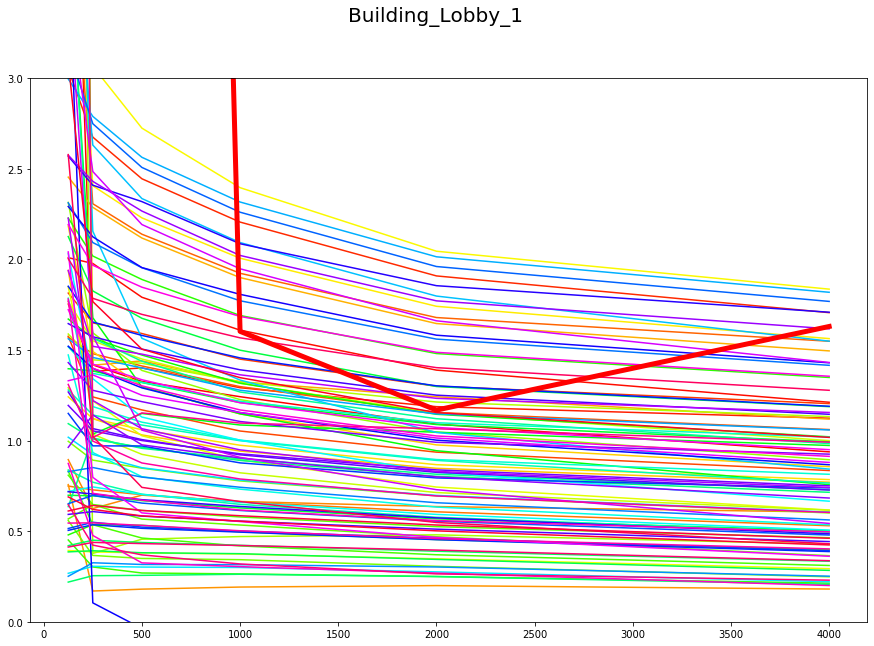

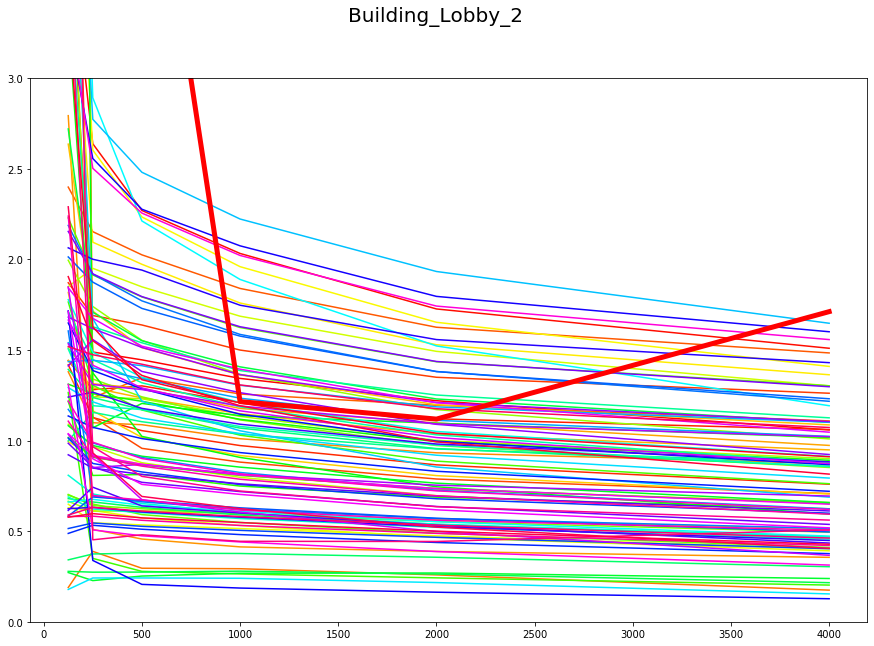

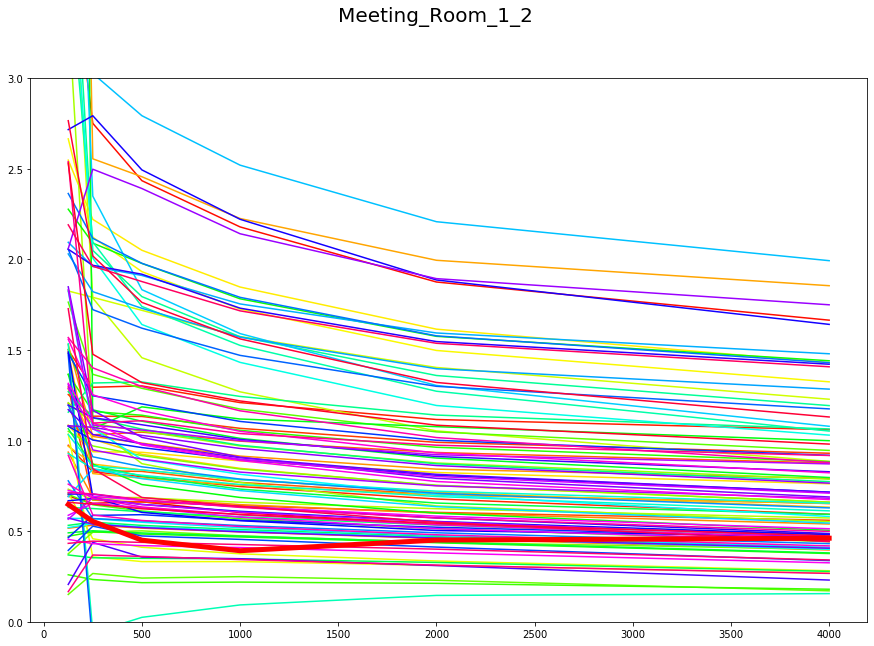

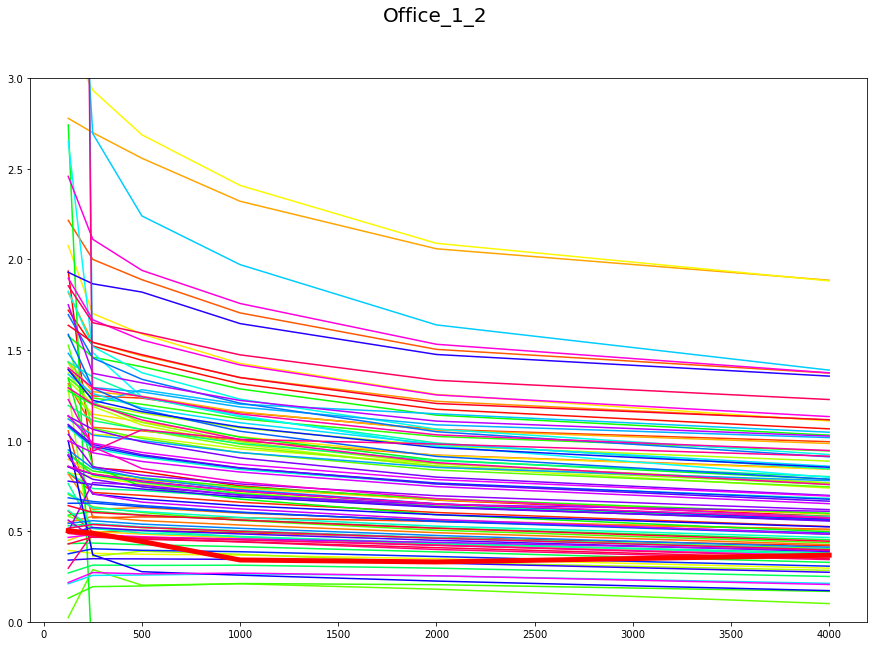

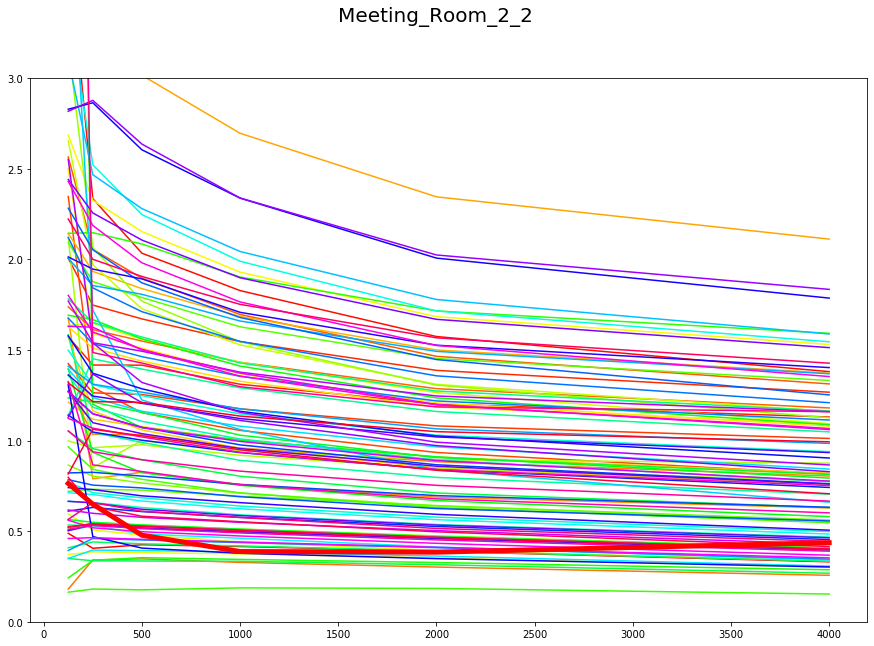

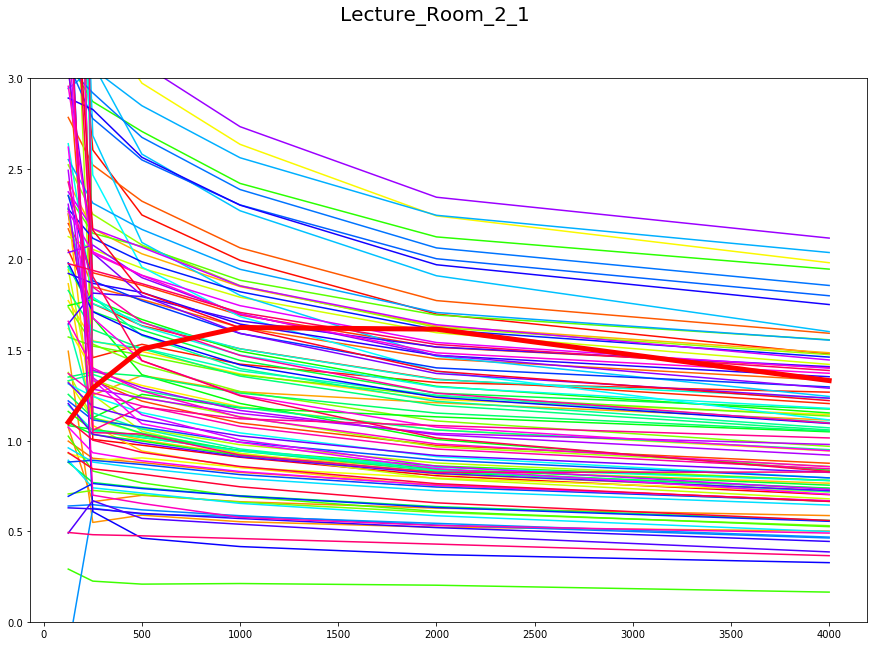

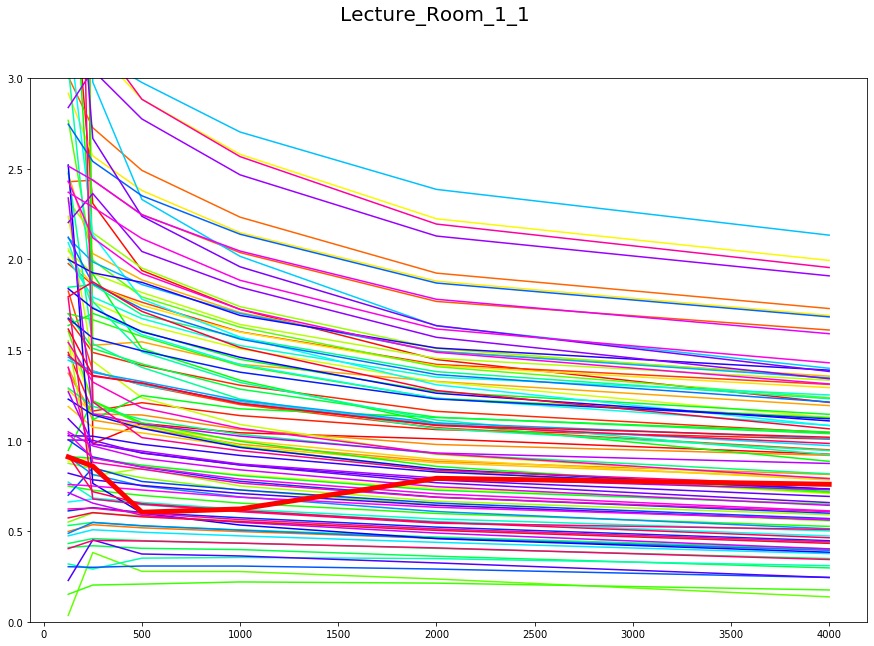

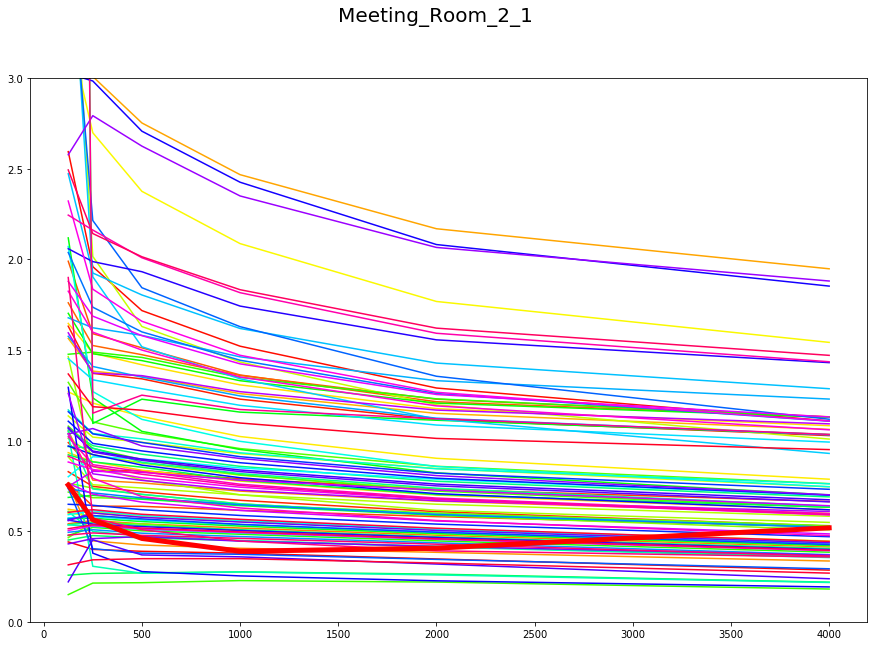

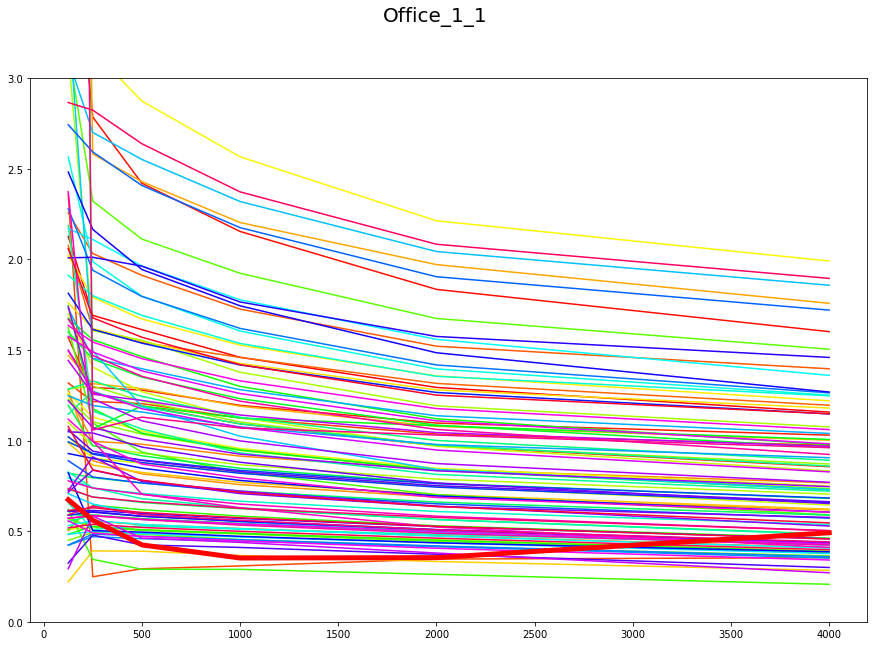

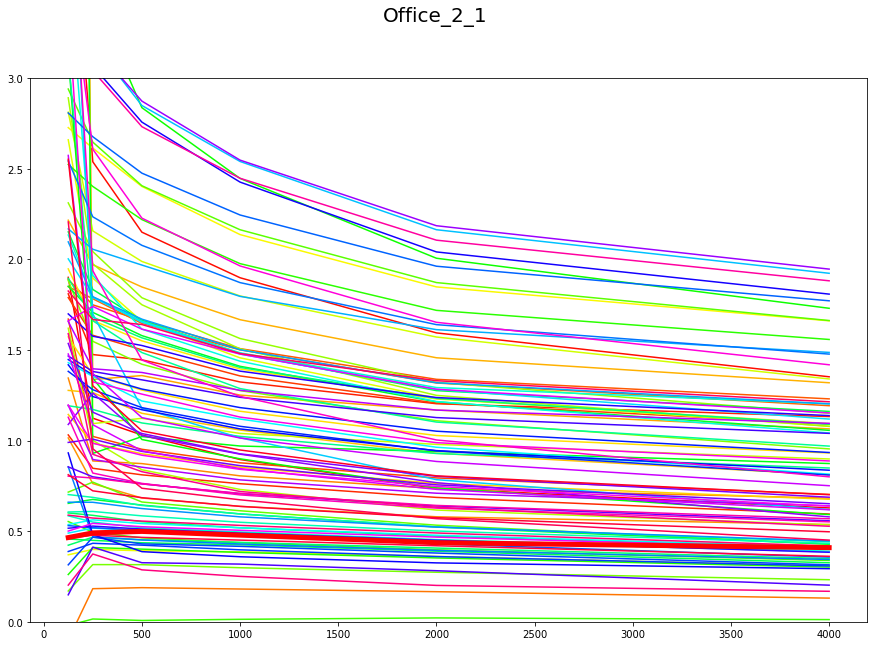

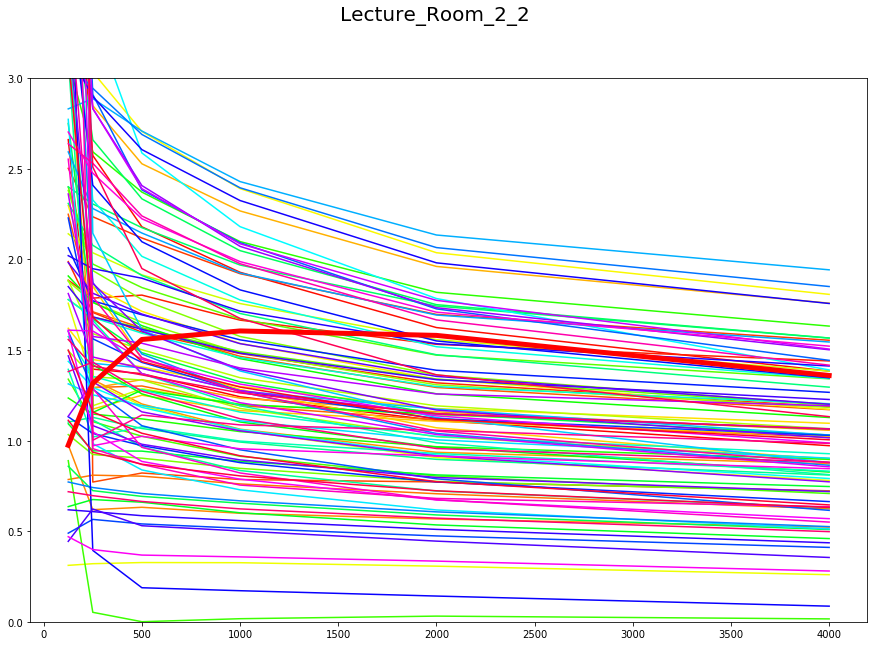

In [47]:
#bands = acoustics.bands.third(500,6000)
bands = [125.,  250.,  500., 1000., 2000., 4000.]

for room in preds_df.columns:
    plot_room_pred(room, preds_df, target_df, bands, 't60')

#### 5. Compute error

In [22]:
(target_df[str(col)].loc['t60'])

array([0.97420333, 1.3161994 , 1.55816357, 1.60516382, 1.58060596,
       1.35935403])

In [20]:
np.vstack(len(preds_arr)*[(target_df[str(col)].t60)])

array([[0.97420333, 1.3161994 , 1.55816357, 1.60516382, 1.58060596,
        1.35935403],
       [0.97420333, 1.3161994 , 1.55816357, 1.60516382, 1.58060596,
        1.35935403],
       [0.97420333, 1.3161994 , 1.55816357, 1.60516382, 1.58060596,
        1.35935403],
       [0.97420333, 1.3161994 , 1.55816357, 1.60516382, 1.58060596,
        1.35935403],
       [0.97420333, 1.3161994 , 1.55816357, 1.60516382, 1.58060596,
        1.35935403],
       [0.97420333, 1.3161994 , 1.55816357, 1.60516382, 1.58060596,
        1.35935403],
       [0.97420333, 1.3161994 , 1.55816357, 1.60516382, 1.58060596,
        1.35935403],
       [0.97420333, 1.3161994 , 1.55816357, 1.60516382, 1.58060596,
        1.35935403],
       [0.97420333, 1.3161994 , 1.55816357, 1.60516382, 1.58060596,
        1.35935403],
       [0.97420333, 1.3161994 , 1.55816357, 1.60516382, 1.58060596,
        1.35935403],
       [0.97420333, 1.3161994 , 1.55816357, 1.60516382, 1.58060596,
        1.35935403],
       [0.97420333, 1

In [18]:
from sklearn.metrics import mean_absolute_error

In [19]:
res_arr = np.empty(len(preds_df))
for i,col in enumerate(preds_df.columns):
    preds_arr = np.vstack(preds_df[str(col)].values)
    target_arr = np.vstack(len(preds_arr)*[(target_df[str(col)].t60)])
    res_arr[i] = mean_absolute_error(target_arr,preds_arr)
    

In [50]:
preds_arr[0]

array([2.660955 , 1.3944464, 1.3695068, 1.2418196, 1.1110926, 0.9718977],
      dtype=float32)

In [51]:
res_arr.mean()

0.20283204658815443

#### 5. Compute error on mean results

In [52]:
res_arr_mean = np.empty(len(preds_df_mean))
for i,col in enumerate(preds_df_mean.columns):
    preds_arr = np.vstack(preds_df_mean[str(col)].values)
    target_arr = np.vstack(len(preds_arr)*[(target_df_ace[str(col)].t60)])
    res_arr_mean[i] = mean_absolute_error(target_arr,preds_arr)
res_arr_mean.mean()


1.1734218038810902

In [53]:
target_df_ace.T.t60

Office_2_2          0.39
Meeting_Room_1_1    0.44
Lecture_Room_1_2    0.64
Building_Lobby_1    0.65
Building_Lobby_2    0.65
Meeting_Room_1_2    0.44
Office_1_2          0.34
Meeting_Room_2_2    0.37
Lecture_Room_2_1    1.25
Lecture_Room_1_1    0.64
Meeting_Room_2_1    0.37
Office_1_1          0.34
Office_2_1          0.39
Lecture_Room_2_2    1.25
Name: t60, dtype: float64

In [54]:
preds_df_mean.mean()

Office_2_2          1.464094
Meeting_Room_1_1    0.989234
Lecture_Room_1_2    1.128881
Building_Lobby_1    1.224975
Building_Lobby_2    1.192215
Meeting_Room_1_2    1.045021
Office_1_2          0.923054
Meeting_Room_2_2    1.131981
Lecture_Room_2_1    1.512649
Lecture_Room_1_1    1.315961
Meeting_Room_2_1    1.002469
Office_1_1          1.098824
Office_2_1          1.233967
Lecture_Room_2_2    1.680130
dtype: float64

In [55]:
pa = 't60'
target_df_ace.T.eval(pa)

Office_2_2          0.39
Meeting_Room_1_1    0.44
Lecture_Room_1_2    0.64
Building_Lobby_1    0.65
Building_Lobby_2    0.65
Meeting_Room_1_2    0.44
Office_1_2          0.34
Meeting_Room_2_2    0.37
Lecture_Room_2_1    1.25
Lecture_Room_1_1    0.64
Meeting_Room_2_1    0.37
Office_1_1          0.34
Office_2_1          0.39
Lecture_Room_2_2    1.25
Name: t60, dtype: float64

In [56]:
def compute_error_percent(param,size):
    error = np.empty(size)
    error_abs = np.empty(size)

    for i in range(size):
        error_abs[i] = 100*abs((target_df_ace.T.eval(param)[i]-preds_df_mean.mean()[i])/target_df_ace.T.eval(param)[i])
        error[i] = 100*(target_df_ace.T.eval(param)[i]-preds_df_mean.mean()[i])/target_df_ace.T.eval(param)[i]
    return (error)

In [57]:
error = compute_error('drr',14)
print(error)

NameError: name 'compute_error' is not defined

In [116]:
def compute_error(param,size):
    error = np.empty(size)
    for i in range(size):
        error[i] = target_df_ace.T.eval(param)[i]-preds_df_mean.mean()[i]
    return(error)

NameError: name 'error' is not defined

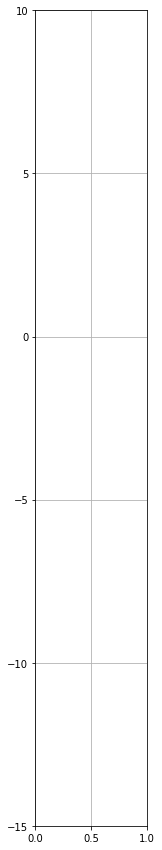

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(2,15))
plt.ylim(bottom=-15,top=10)
plt.grid()
B = plt.boxplot(error,
                vert=True,  # vertical box alignment
                patch_artist=True,
               labels = ['preds'])

In [58]:
def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

In [61]:
get_box_plot_data(['error'],B)

label  lower_whisker  lower_quartile    median  upper_quartile  \
0  error     -37.212523      -23.744947 -6.358777        9.415293   

   upper_whisker  
0      24.597802

## Garbage

In [9]:

dataset_folder = output_folder

output_size = 13
bands = acoustics.bands.third(500,8000)
#room_folder = dataset_folder + 'X/'


In [25]:
def plot_room_prediction(room_preds,room_name,track_names):
    bands = [125.,  250.,  500., 1000., 2000., 4000.]#acoustics.bands.third(500,8000)
    #plt.title(name)
    fig = plt.figure(figsize=(15,10))
    
    fig.suptitle(room_name, fontsize=20)
    plt.xscale('log')
    plt.ylim(bottom=0,top=1.5)
    for track in room_preds:
        plt.plot(bands, track) 
    plt.legend((track_names))
    plt.show(fig)

In [11]:
def plot_mean_prediction_vs_true(room_preds,room_true,room_name):
    bands = acoustics.bands.third(500,8000)
    #plt.title(name)
    fig = plt.figure(figsize=(15,10))
    
    fig.suptitle(room_name, fontsize=20)
    plt.xscale('log')
    plt.ylim(bottom=0,top=1.5)
    mean_preds = np.mean(room_preds,axis=0)
    
    plt.plot(bands, mean_preds) 
    #plt.legend((track_names))
    #plt.show(fig)
    
    #fig.suptitle(room_name, fontsize=20)
    #plt.xscale('log')
    #plt.ylim(bottom=0,top=1.5)
    for track in room_true:
        plt.plot(bands, track) 
    plt.legend((['True RT60','mean predicted RT60']))
    plt.show(fig)

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [13]:
def boxplot_room_prediction(room_preds,room_name,track_names):
    bands = acoustics.bands.third(500,8000)
    #plt.title(name)
    fig = plt.figure(figsize=(15,10))
    
    fig.suptitle(room_name, fontsize=20)
    plt.xscale('log')
    plt.ylim(bottom=0,top=1.5)
    
    plt.boxplot(room_preds[:,:],labels = bands)
    #for track in room_preds:
    #    plt.boxplot(bands,track[:,:]) 
    plt.legend((track_names))
    plt.show(fig)

In [14]:
def boxplot_room_prediction_test(room_preds,room_true,room_name,track_names):
    bands = acoustics.bands.third(500,8000)
    #plt.title(name)
    fig = plt.figure(figsize=(15,10))
    plt.xscale('log')
    plt.plot(bands, room_true) 
    fig.suptitle(room_name, fontsize=20)
    
    plt.ylim(bottom=0,top=1.5)
    locs, labels = plt.xticks()
    plt.boxplot(room_preds[:,:],positions = bands)
    plt.xticks(locs)
    #for track in room_preds:
    #    plt.boxplot(bands,track[:,:]) 
    plt.legend((track_names))
    plt.show(fig)

In [15]:
def plot_mean_prediction_vs_true_errbar(room_preds,room_true,room_name):
    bands = acoustics.bands.third(500,8000)
    #plt.title(name)
    fig = plt.figure(figsize=(15,10))
    
    fig.suptitle(room_name, fontsize=20)
    plt.xscale('log')
    plt.ylim(bottom=0,top=1.5)
    mean_preds = np.mean(room_preds,axis=0)
    
    print(len(room_preds[0]))
    
    error = []
    for i in range(len(room_preds[0])):
        #print(room_preds[i,:])
        quantiles = np.percentile(room_preds[i,:], [25,75])
        quantiles = [np.mean(room_preds[i]) - quantiles[0], quantiles[1] - np.mean(room_preds[i])]
        error.append(quantiles)
        
    error = np.array(error).T
    print(f'error ; {error} \n shape : {error.shape}')
    #print(len(error[1]))
    plt.errorbar(bands,  mean_preds,yerr=error,capsize=10) 
    #plt.legend((track_names))
    #plt.show(fig)
    
    #fig.suptitle(room_name, fontsize=20)
    #plt.xscale('log')
    #plt.ylim(bottom=0,top=1.5)
    for track in room_true:
        plt.plot(bands, track) 
    plt.legend((['True RT60','predicted RT60']))
    plt.show(fig)

In [ ]:
for room_folder_num in glob.glob(dataset_folder+'X/*'):
    room_name = os.path.split(room_folder_num)[1]
    track_names = [os.path.split(track)[1] for track in glob.glob(room_folder_num + '/*.pkl')]
    #print(f'roomfolder : {room_folder_num}')
    
    #print(rir_folder)
    rir,fs = librosa.load(rir_folder + room_name + '_RIR.wav')
    true_t60 = t60_impulse(rir,fs,bands)
    #print(f'{room_name} : {true_t60}')
    
    
    plot_mean_prediction_vs_true_errbar(room_prediction(room_folder_num,params),[true_t60],room_name=room_name)


    #plot_room_prediction([true_t60], room_name=room_name, track_names = ['True RT60'],show=False)
    #print(np.mean(room_prediction(room_folder_num,params),axis=0).shape)
    #plot_room_prediction([np.mean(room_prediction(room_folder_num,params),axis=0)],room_name=room_name,track_names='Mean predicted RT60')
    #boxplot_room_prediction_test(room_prediction(room_folder_num,params),true_t60,room_name=room_name,track_names=track_names)
    
    


    #plot_mean_prediction_vs_true(room_prediction(room_folder_num,params),[true_t60],room_name=room_name)
    boxplot_room_prediction(room_prediction(room_folder_num,params),room_name=room_name,track_names=track_names)
    plot_room_prediction(room_prediction(room_folder_num,params),room_name=room_name,track_names=track_names)
    

In [ ]:
for room_folder_num in glob.glob(dataset_folder+'X/*'):
    room_name = os.path.split(room_folder_num)[1]
    track_names = [os.path.split(track)[1] for track in glob.glob(room_folder_num + '/*.pkl')]
    print(f'roomfolder : {room_folder_num}')
    
    #print(room_name)
    #rir,fs = librosa.load(rir_folder + room_name + '_RIR.wav')
    #true_t60 = t60_impulse(rir,fs,bands)
    #print(f'{room_name} : {true_t60}')
    
    
    #plot_mean_prediction_vs_true_errbar(room_prediction(room_folder_num,params),[true_t60],room_name=room_name)


    #plot_room_prediction([true_t60], room_name=room_name, track_names = ['True RT60'],show=False)
    #print(np.mean(room_prediction(room_folder_num,params),axis=0).shape)
    #plot_room_prediction([np.mean(room_prediction(room_folder_num,params),axis=0)],room_name=room_name,track_names='Mean predicted RT60')
    #boxplot_room_prediction_test(room_prediction(room_folder_num,params),true_t60,room_name=room_name,track_names=track_names)
    
    


    #plot_mean_prediction_vs_true(room_prediction(room_folder_num,params),[true_t60],room_name=room_name)
    boxplot_room_prediction(room_prediction(room_folder_num,params),room_name=room_name,track_names=track_names)
    plot_room_prediction(room_prediction(room_folder_num,params),room_name=room_name,track_names=track_names)
    

In [1]:
%cd ..

/home/pcallens/music-parameters-estimation


In [2]:
import pandas as pd

test = pd.read_csv('predictions.csv',index_col=0)

In [14]:
test.iloc[1,1]

'[[3.4497247 3.3226511 2.9863362 2.8020828 2.5715122 2.4585242]]'